<a href="https://colab.research.google.com/github/prince90038/corona-prediction/blob/main/Covid_19_Classification_Based_on_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Covid-19 Classification Based On Chest X-Ray#

Mount the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the Dataset File

In [2]:
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/COVID-19 Radiography Database.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


Importing the Libraries

In [31]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import random
import shutil

#Creating Custom Dataset#

In [5]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir, 'validation'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))
        os.mkdir(os.path.join(root_dir, 'validation', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 255)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

    for c in class_names:
            images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
            selected_images = random.sample(images, 10)
            for image in selected_images:
                source_path = os.path.join(root_dir, c, image)
                target_path = os.path.join(root_dir, 'validation', c, image)
                shutil.move(source_path, target_path)

    for c in class_names:
        shutil.move(os.path.join(root_dir, c), os.path.join(root_dir, 'train'))

#Data Pre-processing Phase#

In [46]:
TrainingImagePath='/content/COVID-19 Radiography Database/train'
TestImagePath='/content/COVID-19 Radiography Database/test'


train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range = 0.1,
        zoom_range = 0.1,
        horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        TrainingImagePath,
        target_size = (256, 256),
        batch_size = 32,
        class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(
        TestImagePath,
        target_size = (256, 256),
        batch_size = 32,
        class_mode = 'categorical')

test_set.class_indices

Found 3034 images belonging to 3 classes.
Found 765 images belonging to 3 classes.


{'covid': 0, 'normal': 1, 'viral': 2}

In [47]:
TrainClasses = training_set.class_indices

labels = {}
for xrayName, xrayValue in TrainClasses.items():
    labels[xrayValue] = xrayName

print('<---------- Mapping of Dataset ----------->')
for key, value in labels.items():
    print(str(key) + " : " + value)

OutputNeurons = len(labels)
print('\nThe Number of Output Neurons Required: ', OutputNeurons)

<---------- Mapping of Dataset ----------->
0 : covid
1 : normal
2 : viral

The Number of Output Neurons Required:  3


#CNN Model#

Initializing the Convolutional Neural Network

In [48]:
cnn = Sequential()

#Step:1#

#Convolution#


Adding the first layer of CNN

In [49]:
cnn.add(Convolution2D(32, kernel_size=(5, 5), strides=(1, 1), input_shape=(256,256,3), activation='relu'))

#Step:2#
#MAX Pooling#

In [50]:
cnn.add(MaxPool2D(pool_size=(2,2)))

#Addtional Layer of Convulution# 

In [51]:
cnn.add(Convolution2D(64, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

In [52]:
cnn.add(Convolution2D(128, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))

#Step:3# 
#Flattening#

In [53]:
cnn.add(Flatten())

#Step:4#
#Fully Connected Neural Network#

In [54]:
cnn.add(Dense(200))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Activation('relu'))
cnn.add(Dense(100))
cnn.add(Activation('relu'))
cnn.add(Dropout(0.5))
cnn.add(Activation('relu'))
cnn.add(Dense(OutputNeurons, activation='softmax'))

#Compiling the CNN#

In [55]:
cnn.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])

#Start Training the Model#

In [56]:
StartTime=time.time()
classifier = cnn.fit(
                    training_set,
                    # steps_per_epoch=160,
                    epochs=20,
                    validation_data=test_set,
                    validation_steps=20)

EndTime = time.time()
print()
print("*"*137)
print('Total Time Taken to Train the Model: ', round((EndTime-StartTime)/60), 'Minutes')

Epoch 1/20
95/95 [==============================] - 76s 793ms/step - loss: 1.1431 - accuracy: 0.4884 - val_loss: 0.3884 - val_accuracy: 0.8797
Epoch 2/20
95/95 [==============================] - 75s 785ms/step - loss: 0.5362 - accuracy: 0.7997 - val_loss: 0.2475 - val_accuracy: 0.9062
Epoch 3/20
95/95 [==============================] - 74s 785ms/step - loss: 0.3956 - accuracy: 0.8572 - val_loss: 0.2421 - val_accuracy: 0.9281
Epoch 4/20
95/95 [==============================] - 75s 787ms/step - loss: 0.3580 - accuracy: 0.8728 - val_loss: 0.2056 - val_accuracy: 0.9359
Epoch 5/20
95/95 [==============================] - 75s 785ms/step - loss: 0.3104 - accuracy: 0.8881 - val_loss: 0.2194 - val_accuracy: 0.9187
Epoch 6/20
95/95 [==============================] - 74s 783ms/step - loss: 0.3152 - accuracy: 0.8957 - val_loss: 0.1803 - val_accuracy: 0.9406
Epoch 7/20
95/95 [==============================] - 75s 787ms/step - loss: 0.2885 - accuracy: 0.8993 - val_loss: 0.1682 - val_accuracy: 0.9391

#Training and Validation Accuracy Graph#

[]

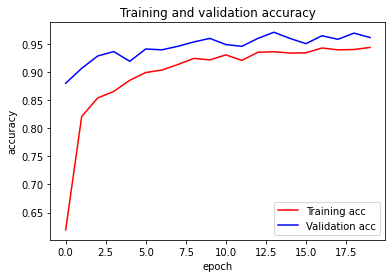

In [57]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.plot()

#Training and Validation Loss Graph#

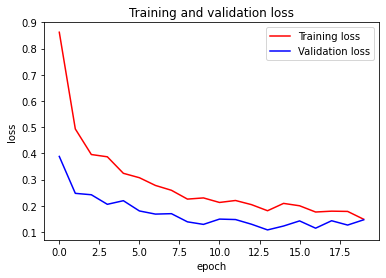

In [58]:
acc = classifier.history['accuracy']
val_acc = classifier.history['val_accuracy']
loss = classifier.history['loss']
val_loss = classifier.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()


#Final Prediction#

Text(0, 0.5, 'viral')

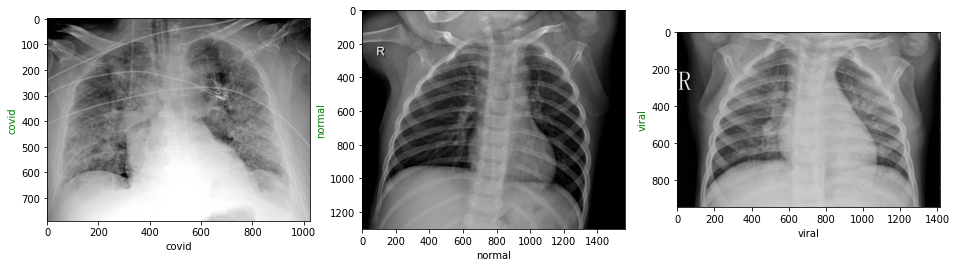

In [68]:
fig = plt.figure(figsize=(16, 10))

rows = 1
columns = 3

fig.add_subplot(rows, columns, 1)
ImagePath = '/content/drive/MyDrive/Covid-19 validation images/covid_p2.jpg'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image,verbose=0)

plt.imshow(Image)
col = 'green' if labels[0] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[0])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 2)

ImagePath = '/content/drive/MyDrive/Covid-19 validation images/normal8.jpeg'
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image,verbose=0)
Image = cv2.imread(ImagePath)

plt.imshow(Image)
col = 'green' if labels[1] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[1])
plt.ylabel(labels[np.argmax(result)], color=col)

fig.add_subplot(rows, columns, 3)
ImagePath = '/content/drive/MyDrive/Covid-19 validation images/pneumonia6.jpeg'
Image = cv2.imread(ImagePath)
test_image = image.load_img(ImagePath,target_size=(256, 256))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image,axis=0)
result = cnn.predict(test_image,verbose=0)

plt.imshow(Image)
col = 'green' if labels[2] == labels[np.argmax(result)] else 'red'
plt.xlabel(labels[2])
plt.ylabel(labels[np.argmax(result)], color=col)